In [ ]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Experiment Parameters

In [ ]:
experiment = {
    'TYPE': 'train',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'GPU' or 'TPU'

    'IMAGE_SIZE': (1024, 1024),
    'INPUT_SHAPE': (1024, 1024, 3),
    'VALID_SIZE': 0.1,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': True,       # Apply data augmentation

    'BACKBONE': 'custom', # Or 'custom' TODO: Add ResNet model
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 8,
    'EPOCHS': 500,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 0.0001,  # 1e-4

    'PERP_LOSS_LAMBDA': 1,
    'RECONS_LOSS': 'PERCEPTUAL',     # reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    'MSE_LOSS_LAMBDA': 0.01,  # MSE coeff
    'SAVE_WEIGHTS_PER_EPOCH': 10,

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 500,

    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "tf_vae/BD67_dataset/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "tf_vae/BD67_dataset/images",
}

In [ ]:
if experiment['ACCELERATOR'] == 'TPU':
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(resolver)

    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    print("All devices:  ", tf.config.list_logical_devices('TPU'))
    print("All replicas: ", strategy.num_replicas_in_sync)

In [ ]:
import zipfile

# Unzip the downloaded file
def unzip_data(zip_file_name, dest):
  zip_ref = zipfile.ZipFile(zip_file_name, "r")
  zip_ref.extractall(dest)
  zip_ref.close()

In [ ]:
# DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset.zip'
# unzip_data(DATASET_PATH, ROOT_PATH)

In [ ]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'

In [ ]:
import os

BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')

In [ ]:
# Create a function to import an image and resize it to be able to be used with our model
def load_images(filename, img_size=None, scl=True):
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  if img_size != None:
    img = tf.image.resize(img, size = img_size, preserve_aspect_ratio=False)

  # Rotate images 270 degree due to capturing photos in vertical position with iPhone
  img = tf.image.rot90(img, k=3)

  # Cast to float32
  img = tf.cast(img, tf.float32)

  # Rescale the image (get all values between 0 and 1)
  if scl == True: img = img / 255.
  return img

In [ ]:
import glob   # In order to get images as matrices from directory

def get_imgs_from_directory_as_numpy_array(dir, ext, img_size=None, scl=None):
    formats = ['jpg', 'png', 'jpeg', 'JPG', 'JPEG', 'PNG']

    if ext in formats:
        rgx_for_img = dir + "/*." + ext
        img_list = glob.glob(rgx_for_img)
    def process_images(filename):
        return load_images(filename, img_size, scl)

    return np.array(list(map(process_images, img_list)))
    # https://keras.io/api/preprocessing/image/
    # https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

### Prepare Data

In [ ]:
def create_dataset_pipeline(img_dir, shuffle=False):
    # Read images from directory and reshape, scale
    dataset = tf.data.Dataset.from_tensor_slices(get_imgs_from_directory_as_numpy_array(dir=img_dir, ext='JPG', img_size=experiment['IMAGE_SIZE'], scl=True))
    # Get image pairs for data pipeline (as an autoencoder input) - Comment the line below if you train CVAE
    # dataset = dataset.map(lambda image: (image, image), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Shuffle (only training set) and create batches
    if shuffle == True:
        dataset = dataset.shuffle(50)
    dataset = dataset.batch(experiment['BATCH_SIZE'])
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
train_dataset = create_dataset_pipeline(BD67_NORMAL_FRONT_PATH)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 1024, 1024, 3), dtype=tf.float32, name=None)>

* The `cache()` method is used to cache elements of a dataset in memory or on disk. Caching allows you to `store a portion` or the entire `dataset` in a format that can be quickly accessed during training `without repeatedly reading the data from its source` (e.g., files on disk). It helps reduce data loading time during training. When you call dataset.cache(), it caches the dataset's elements in memory by default. If you want to cache to disk, you can provide a filename as an argument to the cache() method. Caching can significantly speed up training if data loading is a bottleneck in your pipeline.

* The `prefetch()` method is used to `overlap data loading` and model training, which can lead to improved training performance. When you prefetch data, the dataset pipeline `fetches` the `next batch` of data asynchronously `while the current batch is being processed` by the model. This can help hide data loading latency and ensure that the GPU or CPU is fully utilized during training.

* `tf.data.experimental.AUTOTUNE` is used as an argument to the prefetch() method. This value allows TensorFlow to `dynamically adjust` the number of elements prefetched based on the `available system resources` and workload. It tries to optimize the prefetching for the best performance automatically.

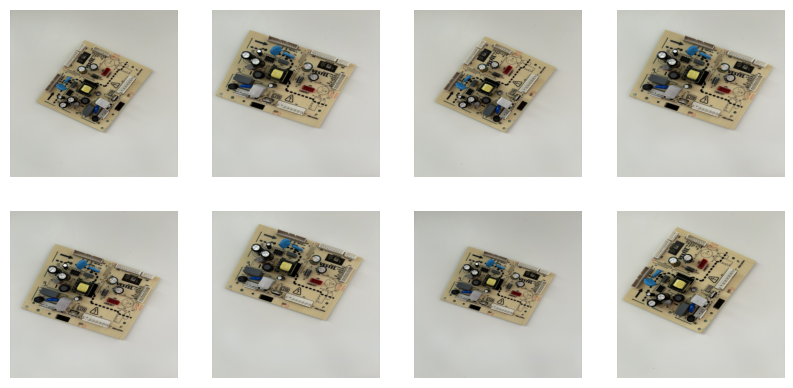

In [ ]:
image_batch = next(iter(train_dataset))

fig = plt.figure(figsize=(10, 10))

for index, image in enumerate(image_batch):  # Get first batch
  plt.subplot(4, 4, index + 1)
  plt.imshow(image[:, :, :])
  plt.axis('off')

### Convolutional Autoencoder Architecture

based on "*Image Based Detection of Modifications in Assembled PCBs with Deep Convolutional Autoencoders*" literature.

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.layers import LeakyReLU, Lambda, ReLU, Concatenate
from tensorflow.keras.models import Model

### Data Augmentation Layer

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  tf.keras.layers.RandomBrightness(factor=0.2, seed=None),
  tf.keras.layers.RandomContrast(0.2, seed=None)
  # tf.keras.layers.RandomCrop(256, 256, seed=None, **kwargs)
  #preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  #preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

### Encoder Network

This defines the approximate posterior distribution `q(z|x)`, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation `z`. In this example, simply model the distribution as a `diagonal Gaussian`, and the network outputs the `mean` and `log-variance` parameters of a factorized Gaussian. Output `log-variance` instead of the variance directly for numerical stability.

In [ ]:
from tensorflow.keras import layers

In [ ]:
def create_encoder_model(input_encoder, latent_dim):
    inputs = keras.Input(shape=input_encoder, name='input_layer')

    if experiment['DATA_AUG'] == True:
        inputs = data_augmentation(inputs)

    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block-4
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

    # Block-5
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
    x = layers.BatchNormalization(name='bn_5')(x)
    x = layers.LeakyReLU(name='lrelu_5')(x)

    # Final Block
    flatten = layers.Flatten()(x)  # (None, 7, 7, 64) to (None, 3136)

    # Latent variables
    mean = layers.Dense(latent_dim, name='mean')(flatten)
    log_var = layers.Dense(latent_dim, name='log_var')(flatten)
    # Model
    model = Model(inputs, (mean, log_var), name="Encoder")

    model.summary()
    keras.utils.plot_model(model, "encoder_model.png")
    return model

### Decoder network

This defines the conditional distribution of the observation `p(x|z)`, which takes a `latent sample` as `input` and `outputs` the parameters for a `conditional distribution` of the observation. Model the latent distribution prior `p(z)` as a unit Gaussian.

In [ ]:
def create_decoder_model(input_decoder):
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    if experiment['IMAGE_SIZE'] == (1024, 1024):
      x = layers.Dense(65536, name='dense_1')(inputs)
      x = layers.Reshape((32, 32, 64), name='Reshape_Layer')(x)
    else:
      x = layers.Dense(16384, name='dense_1')(inputs)
      x = layers.Reshape((16, 16, 64), name='Reshape_Layer')(x)

    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)

    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)

    # Block-3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)

    # Block-4
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)

    # Block-5
    outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
    model = Model(inputs, outputs, name="Decoder")

    model.summary()
    keras.utils.plot_model(model, "decoder_model.png")
    return model

### The Sampling Network

In [ ]:
from keras import backend as K

def sampling_reparameterization_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    z = mean + K.exp(log_var / 2) * epsilon   # z = μ + ε*log(σ)*0.5
    return z

### Reparameterization trick

To generate a sample `z` for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation `x`. However, this sampling operation creates a bottleneck because `backpropagation cannot flow through a random node`. To address this issue, we use a `reparameterization trick`.

![](https://learnopencv.com/wp-content/uploads/2020/11/reparam-vae-1024x479.jpg)

![](https://mlarchive.com/wp-content/uploads/2022/10/Screen-Shot-2022-10-08-at-1.59.49-PM-1-768x225.png)

Generate epsilon from standard normal distribution. The latent variable z is now generated by a function of mean, variance and epsilon, which would enable the model to backpropagate gradients in the encoder through mean and variance respectively, while maintaining stochasticity through epsilon.

In [ ]:
def sampling(input_mean, input_logvar):
    mean = keras.Input(shape=input_mean, name='input_mean')
    log_var = keras.Input(shape=input_logvar, name='input_logvar')

    out = layers.Lambda(sampling_reparameterization_model, name='encoder_output')([mean, log_var])
    enc_2 = keras.Model([mean, log_var], out,  name="Encoder_2")

    enc_2.summary()
    keras.utils.plot_model(enc_2, "sampling_model.png")
    return enc_2

### Loss Functions and Optimizer

![](https://miro.medium.com/v2/resize:fit:720/0*jhi0jGQl9rZoqOvI)

In [ ]:
def mse_loss(y_true, y_pred):
    r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

In [ ]:
def mae_loss(y_true, y_pred):
    r_loss = K.mean(K.abs(y_true - y_pred), axis = [1,2,3])
    return 1000 * r_loss

In [ ]:
def kl_loss(mean, log_var):
    kl_loss_result =  -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
    return kl_loss_result

In [ ]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

### MSE Perceptual Loss

Perceptual Loss

In short, the perceptual loss function works by `summing` all the `squared errors` between all the `pixels` and `taking the mean`. This is in contrast to a `per-pixel loss function` which sums all the absolute errors between pixels.


[What is a Perceptual Loss Function?](https://deepai.org/machine-learning-glossary-and-terms/perceptual-loss-function)

[Johnson et al. (2016)](https://arxiv.org/pdf/1603.08155.pdf%7C)

In [ ]:
def init_perceptual_loss(perp_layers, verbose=0):
  perp_model = tf.keras.applications.VGG19(input_shape=(224,224,3))
  modelOutputs = [perp_model.layers[i].output for i in perp_layers]
  model = Model(perp_model.inputs, modelOutputs)
  if verbose > 0:
      model.summary()
  return model

In [ ]:
vgg19_model = init_perceptual_loss([5,8,13,18], 1)

574710816/574710816 [==============================] - 6s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [ ]:
print(f'VGG19 Model layers that will be used for Perceptual Loss are: \n\
 {vgg19_model.layers[5]}\n {vgg19_model.layers[8]}\n\
 {vgg19_model.layers[13]}\n {vgg19_model.layers[18]}')

VGG19 Model layers that will be used for Perceptual Loss are: 


In [ ]:
class MSE_Perceptual(tf.keras.losses.Loss):
  def __init__(self, perc_layers=[5,8,13,18], lambda_mse=0.01, lambda_perc=1, perc_loss=False):
    super(MSE_Perceptual, self).__init__()
    self.loss = None
    self.perc_layers = perc_layers
    self.lambda_mse = lambda_mse
    self.perc_loss = perc_loss
    self.lambda_perc = lambda_perc
    #with strategy.scope():  # TPU
    self.perc_model = init_perceptual_loss(self.perc_layers)
    self.loss_fn = tf.keras.losses.mean_squared_error

  def call(self, y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(tf.math.pow(y_pred,2) - tf.math.pow(y_true,2)))

    if self.perc_loss == True:
        perceptual_loss = []

        y_true_reshape = tf.image.resize(y_true, (224, 224))
        y_pred_reshape = tf.image.resize(y_pred, (224, 224))

        y_true_output = self.perc_model(y_true_reshape)
        y_pred_output = self.perc_model(y_pred_reshape)

        for idx, (y_true_layer, y_pred_layer) in enumerate(zip(y_true_output, y_pred_output)):
          w, h, d = y_pred_layer[0].shape
          perceptual_loss.append((1/(w*h*d))*tf.reduce_mean(tf.square(y_true_layer - y_pred_layer)))
          #perceptual_loss.append((1/(w*h*d))*tf.reduce_sum(tf.square(y_true_layer - y_pred_layer)))

    self.loss = self.lambda_mse*mse_loss
    if self.perc_loss == True:
        self.loss += self.lambda_perc*tf.reduce_sum(perceptual_loss)

    return self.loss

In [ ]:
if (experiment['RECONS_LOSS'] == 'PERCEPTUAL'):
  percep_loss = MSE_Perceptual([5,8,13,18], experiment['MSE_LOSS_LAMBDA'], experiment['PERP_LOSS_LAMBDA'], perc_loss=True)
else:
  percep_loss = MSE_Perceptual(lambda_mse=experiment['MSE_LOSS_LAMBDA'])

Convolutional Variational Autoencoder Total Loss

In [ ]:
def vae_loss(y_true, y_pred, mean, log_var):
    if (experiment['RECONS_LOSS'] == 'MSE'):
        r_loss = mse_loss(y_true, y_pred)
    elif experiment['RECONS_LOSS'] == 'SSIM':
        r_loss = SSIMLoss(y_true, y_pred)
    elif (experiment['RECONS_LOSS'] == 'PERCEPTUAL'):
        r_loss = percep_loss(y_true, y_pred)
    kl_loss_result = kl_loss(mean, log_var)
    return  r_loss + kl_loss_result

### Optimizer

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = experiment['LEARNING_RATE'])

### Training the Model

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of `mean` and `log-variance` parameters of the approximate posterior `q(z|x)` then apply the reparameterization trick to sample from `q(z|x)`
* Pass the `reparameterized samples` to the decoder to obtain the logits of the generative distribution `p(x|z)`

### Get Encoder and Decoder Models

In [ ]:
encoder_model = create_encoder_model(experiment['INPUT_SHAPE'] , experiment['LATENT_DIM'])
decoder_model = create_decoder_model(experiment['LATENT_DIM'])

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 512, 512, 32)         896       ['input_3[0][0]']             
                                                                                                  
 bn_1 (BatchNormalization)   (None, 512, 512, 32)         128       ['conv_1[1][0]']              
                                                                                                  
 lrelu_1 (LeakyReLU)         (None, 512, 512, 32)         0         ['bn_1[1][0]']                
                                                                                            

In [ ]:
input_mean = (experiment['LATENT_DIM'],)
input_logvar = (experiment['LATENT_DIM'],)

In [ ]:
sampling_model = sampling(input_mean, input_logvar)

Model: "Encoder_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_mean (InputLayer)     [(None, 500)]                0         []                            
                                                                                                  
 input_logvar (InputLayer)   [(None, 500)]                0         []                            
                                                                                                  
 encoder_output (Lambda)     (None, 500)                  0         ['input_mean[0][0]',          
                                                                     'input_logvar[0][0]']        
                                                                                                  
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 

In [ ]:
os.makedirs(experiment['TRAINING_WEIGHT_DIR'], exist_ok=True)
os.makedirs(experiment['IMGS_DIR'], exist_ok=True)

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # All layers run in inference mode (batchnorm).
  mean, var = encoder_model(test_input, training=False)
  latent = sampling_model([mean,  var])
  predictions = decoder_model(latent, training=False)

  print("test_input.shape: ", test_input.shape)
  print("mean.shape: ", mean.shape)
  print("var.shape: ", var.shape)
  print("latent.shape: ", latent.shape)
  print("predictions.shape: ", predictions.shape)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.array((predictions[i, :, :, :] * 255)).astype(np.uint8))
    plt.axis('off')

  plt.savefig(experiment['IMGS_DIR'] + '/image_at_epoch_{:d}.png'.format(epoch))
  plt.show()

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
        mean, log_var = encoder_model(images, training=True)
        latent = sampling_model([mean, log_var])   # Reparametrization
        generated_images = decoder_model(latent, training=True)
        loss = vae_loss(images, generated_images, mean, log_var)

    gradients_of_enc = encoder.gradient(loss, encoder_model.trainable_variables)
    gradients_of_dec = decoder.gradient(loss, decoder_model.trainable_variables)

    optimizer.apply_gradients(zip(gradients_of_enc, encoder_model.trainable_variables))
    optimizer.apply_gradients(zip(gradients_of_dec, decoder_model.trainable_variables))
    return loss

In [ ]:
def train(dataset, epochs):
    loss_hist = []  # Keep loss history
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            loss = train_step(image_batch)

        loss_hist.append(loss)   # Add loss value to the loss history after each epoch
        #print("loss: ", loss)

        # Save the model every experiment['SAVE_WEIGHTS_PER_EPOCH'] epochs
        if (epoch + 1) % experiment['SAVE_WEIGHTS_PER_EPOCH'] == 0:
          seed = image_batch[:25]
          display.clear_output(wait=True)
          generate_and_save_images([encoder_model, sampling_model, decoder_model],
                                    epoch + 1,
                                    seed)
          encoder_model.save_weights(experiment['TRAINING_WEIGHT_DIR'] + '/encoder_model_'+ str(epoch)+'.h5')
          decoder_model.save_weights(experiment['TRAINING_WEIGHT_DIR'] + '/decoder_model_'+ str(epoch)+'.h5')

          print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images([encoder_model, sampling_model, decoder_model],
                            epochs,
                            seed)
    return loss_hist

In [ ]:
from glob import glob

training_files = glob(BD67_NORMAL_FRONT_PATH + "/*.JPG")
print(f"Number of normal BD67-PCB front side photos: {len(training_files)}")

Number of normal BD67-PCB front side photos: 76


In [ ]:
from sklearn.model_selection import train_test_split
import math

# Get number of training batches according to VALID_SIZE
training_batch_num = len(train_dataset) - math.ceil(len(train_dataset) * experiment['VALID_SIZE'])

# Prepare new training and validation batches
train_dataset_part = train_dataset.take(training_batch_num)
valid_dataset_part = train_dataset.skip(training_batch_num)

training_files, valid_files, _, _ = train_test_split(training_files, training_files, test_size=experiment['VALID_SIZE'], random_state=100)

print(f"Number of Training Images: {len(training_files)}")
print(f"Number of Validation Images: {len(valid_files)}")

print("Number of training batches:   ", len(train_dataset_part))
print("Number of validation batches: ", len(valid_dataset_part))

Number of Training Images: 68
Number of Validation Images: 8
Number of training batches:    9
Number of validation batches:  1


Training Callbacks

In [ ]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath=f"{experiment['TRAINING_WEIGHT_DIR']}/cvae_BD67_ds_best_model_val_loss.h5", monitor='val_loss', save_best_only=True)

test_input.shape:  (8, 1024, 1024, 3)
mean.shape:  (8, 500)
var.shape:  (8, 500)
latent.shape:  (8, 500)
predictions.shape:  (8, 1024, 1024, 3)


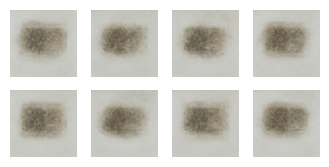

In [ ]:
if experiment['TYPE'] == 'train':
  cvae_model_hist = train(train_dataset_part, experiment['EPOCHS'])

### Loss curve for all batches

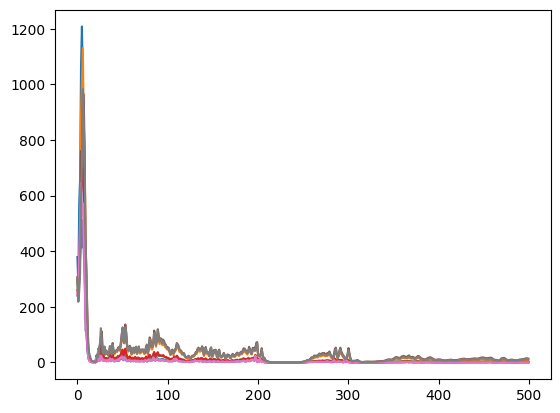

In [ ]:
plt.plot(cvae_model_hist)

### Mean Loss curve

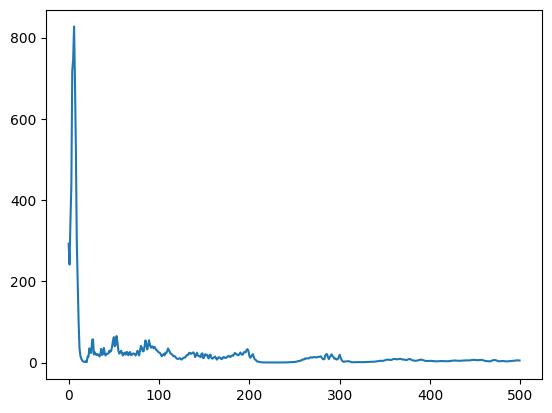

In [ ]:
mean_loss = lambda x: tf.reduce_mean(x)
cvae_model_hist_mean = list(map(mean_loss, cvae_model_hist))

plt.plot(cvae_model_hist_mean)

In [ ]:
TRAINING_WEIGHT_DIR = '.../tf_vae/training_weights'  # Google Drive Directory

if experiment['TYPE'] == 'test':
  # Load weigths that generated with last epoch
  encoder_model.load_weights(TRAINING_WEIGHT_DIR + '/encoder_model_'
                             + str(experiment['EPOCHS'] - 1) + '.h5')
  decoder_model.load_weights(TRAINING_WEIGHT_DIR + '/decoder_model_'
                             + str(experiment['EPOCHS'] - 1) + '.h5')

In [ ]:
def get_model_embeddings(dataset, model='sampling'):
    embeddings=None
    mean=None
    var=None

    for i in dataset:
        m,v = encoder_model.predict(i)
        latent = sampling_model.predict([m,v])
        if not (model == 'sampling' or model == 'decoder'):
            raise ValueError("Valid model types= 'sampling' and 'decoder'")

        if model == 'sampling':
          embed = latent
        else:
          embed = decoder_model.predict(latent)

        if embeddings is None:
            embeddings = embed
            mean = m
            var = v
        else:
            embeddings = np.concatenate((embeddings, embed))
            mean = np.concatenate((mean, m))
            var = np.concatenate((var, v))

        if embeddings.shape[0] > 5000:
            break

    return embeddings

In [ ]:
embeddings = get_model_embeddings(train_dataset_part, model='sampling')
# embeddings = get_model_embeddings(train_dataset_part, model='decoder')
embeddings.shape

1/1 [==============================] - 0s 19ms/step


(72, 500)

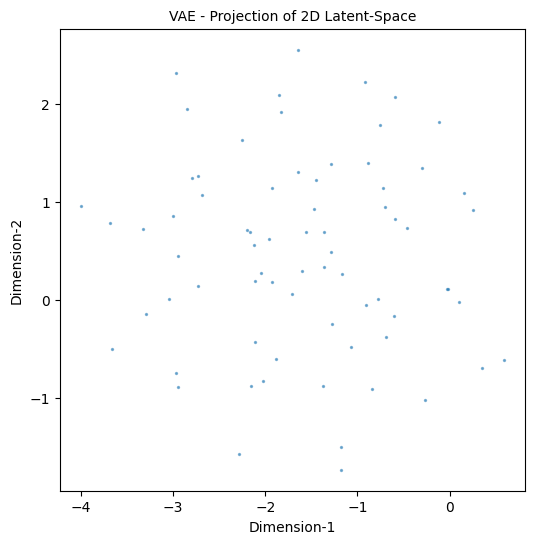

In [ ]:
from sklearn.manifold import TSNE

n_to_show = 5000
grid_size = 15

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embeddings)

min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])

plt.figure(figsize=(6, 6))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=10)
plt.ylabel("Dimension-2", size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.title("VAE - Projection of 2D Latent-Space", size=10)
plt.show()

### Run model in Inference mode - Prediction - Generation

In [ ]:
def get_generated_image_batch(data, model='decoder'):
    reconstructed_batch = None
    latent_space = None

    if not (model == 'sampling' or model == 'decoder'):
        raise ValueError("Valid model types= 'sampling' and 'decoder'")

    for image_batch in data:
      mean, log_var = encoder_model.predict(image_batch)
      latent_vector = sampling_model([mean,log_var])
      generated_batch = decoder_model.predict(latent_vector)

      if reconstructed_batch is None:
          reconstructed_batch = generated_batch
          latent_space = latent_vector
      else:
          reconstructed_batch = np.concatenate((reconstructed_batch, generated_batch))
          latent_space = np.concatenate((latent_space, latent_vector))

      if reconstructed_batch.shape[0] > 5000:
          break

    if model == 'sampling':  return latent_space
    else: return reconstructed_batch

In [ ]:
generated_train_data = get_generated_image_batch(train_dataset_part.take(1))  # Use only first batch
generated_train_data.shape

1/1 [==============================] - 0s 164ms/step


(8, 1024, 1024, 3)

In [ ]:
def show_generated_images(image_batch):
  fig = plt.figure(figsize=(10, 10))
  for index, image in enumerate(image_batch):
    plt.subplot(4, 4, index + 1)
    plt.imshow(image)
    plt.axis('off')
    if index >= 15:
      break
  plt.show()

### Generate Images from Training Data

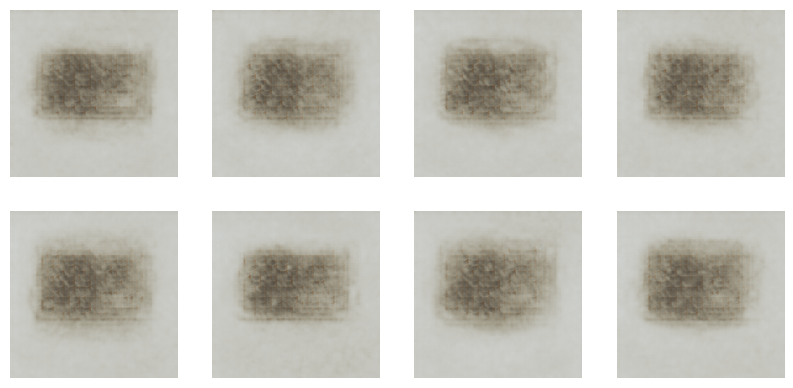

In [ ]:
show_generated_images(generated_train_data)

### Generate Images from Validation Data

1/1 [==============================] - 1s 614ms/step


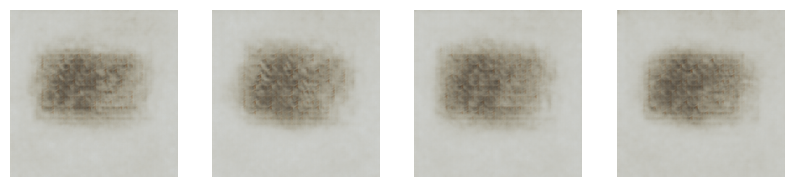

In [ ]:
generated_valid_data = get_generated_image_batch(valid_dataset_part.take(1))  # Use only first batch
show_generated_images(generated_valid_data)

### Generate Images from Testing (Defected) Data

1/1 [==============================] - 0s 309ms/step


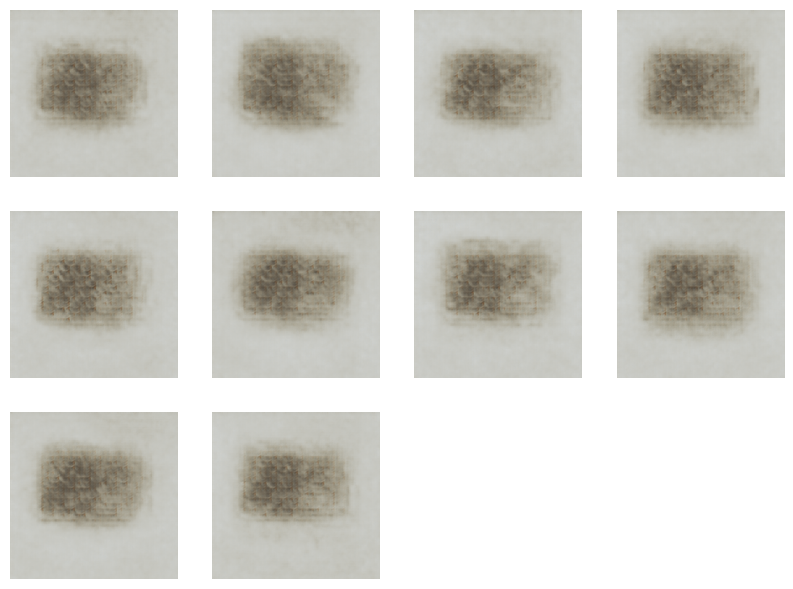

In [ ]:
import glob
test_dataset = create_dataset_pipeline(BD67_DEFECTED_FRONT_PATH)
generated_test_data = get_generated_image_batch(test_dataset)

show_generated_images(generated_test_data)

In [ ]:
def display_pixel_wise_img_diff(img1_dir, img2_dir, threshold=None, verbose=0, channel=0):
  # Load your two images using TensorFlow
  #image1 = tf.image.decode_image(tf.io.read_file(img1_dir))
  #image2 = tf.image.decode_image(tf.io.read_file(img2_dir))
  image1 = img1_dir
  image2 = img2_dir

  # Ensure both images have the same shape and data type
  image1 = tf.cast(image1, tf.float32)
  image2 = tf.cast(image2, tf.float32)

  # Compute pixel-wise absolute differences
  diff = tf.abs(image1 - image2)
  if verbose > 0:  print(f"Difference map shape: {diff.shape}")

  # Define a colormap (e.g., 'jet') and normalize the differences
  cmap = plt.get_cmap('jet')
  norm = plt.Normalize(vmin=0, vmax=tf.reduce_max(diff).numpy())
  norm_diff = norm(diff)
  if verbose > 0:
    print(f"Normalized difference map shape: {norm_diff.shape}")
    print(f"Normalized difference map min, avg, max value: ({np.min(norm_diff)}, {np.mean(norm_diff):.5f}, {np.max(norm_diff)})")

  colored_diff = cmap(norm_diff)
  if verbose > 0:  print(f"Colored difference map shape: {colored_diff.shape}")

  color_diff_plot = colored_diff[:, :, :,channel]

  if threshold != None:
    color_diff_plot[color_diff_plot < threshold] = 0.0

  # Display the color-coded difference map
  plt.imshow(color_diff_plot)
  plt.colorbar()
  plt.axis('off')
  plt.show()

Difference map shape: (1024, 1024, 3)
Normalized difference map shape: (1024, 1024, 3)
Normalized difference map min, avg, max value: (0.0, 0.08433, 1.0)
Colored difference map shape: (1024, 1024, 3, 4)


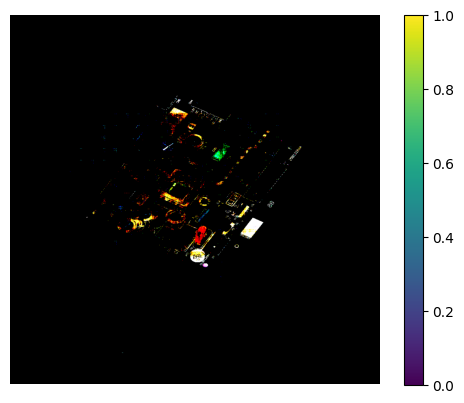

In [ ]:
train_batch = next(iter(train_dataset_part))

display_pixel_wise_img_diff(train_batch[0], generated_train_data[0], threshold=0.8, channel=0, verbose=1)

Difference map shape: (1024, 1024, 3)
Normalized difference map shape: (1024, 1024, 3)
Normalized difference map min, avg, max value: (0.0, 0.09673, 1.0)
Colored difference map shape: (1024, 1024, 3, 4)


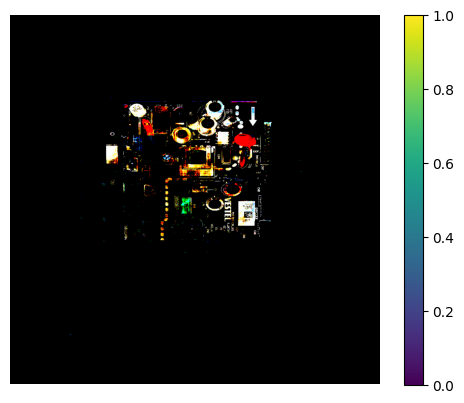

In [ ]:
valid_batch = next(iter(valid_dataset_part))

display_pixel_wise_img_diff(valid_batch[1], generated_valid_data[1], threshold=0.8, channel=0, verbose=1)

Difference map shape: (1024, 1024, 3)
Normalized difference map shape: (1024, 1024, 3)
Normalized difference map min, avg, max value: (0.0, 0.07712, 1.0)
Colored difference map shape: (1024, 1024, 3, 4)


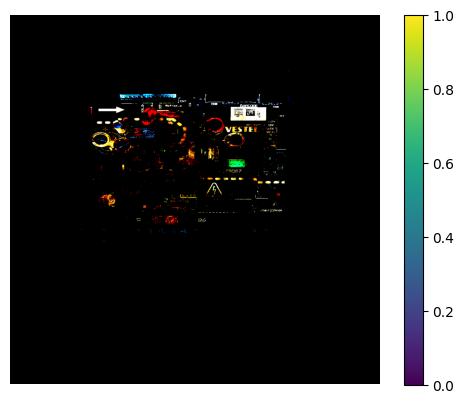

In [ ]:
test_batch = next(iter(test_dataset))

display_pixel_wise_img_diff(test_batch[0], generated_valid_data[0], threshold=0.8, channel=0, verbose=1)

### Learning Rate Decay

In [ ]:
import math

LR_START = 1e-5
LR_MIN = 1e-5
#LR_MAX = 9e-4 * strategy.num_replicas_in_sync
LR_MAX = 9e-4
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = 0.5
EPOCHS = experiment['EPOCHS']

def lrfn(epoch):
  if epoch < LR_RAMPUP_EPOCHS:
    lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
  elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
    lr = LR_MAX
  else:
    progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
    lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
    if LR_MIN is not None:
      lr = tf.math.maximum(LR_MIN, lr)

  return lr

In [ ]:
def predict_perpdiff(dataset, ds_imgs):
  vgg19_perp_model = tf.keras.applications.VGG19(input_shape=(224,224,3))
  modelOutputs = [vgg19_perp_model.layers[i].output for i in [12]]  # Set 12th layer for the model output layer
  vgg19_perp_model = Model(vgg19_perp_model.inputs, modelOutputs)

  for ds_imgs in dataset.take(1):
    input_imgs = ds_imgs.numpy()

    mean, log_var = encoder_model.predict(ds_imgs)
    latent_vector = sampling_model([mean,log_var])
    y_pred = decoder_model.predict(latent_vector)

    print("y_pred.shape: ", y_pred.shape)

    # Predict the reconstructed image
    #y_pred = model.predict(input_imgs)

    # Resize the images to the input size of VGG19
    y_true_reshape = tf.image.resize(input_imgs, (224, 224))
    y_pred_reshape = tf.image.resize(y_pred, (224, 224))
    # mask1_reshape = tf.image.resize(ds_imgs[1], (224, 224))
    # mask2_reshape = tf.image.resize(ds_imgs[2], (224, 224))
    print("y_true_reshape.shape: ", y_true_reshape.shape)

    # Pass all images in the VGG19 and get the perceptual layers outputs
    perp_input = vgg19_perp_model([y_true_reshape])
    perp_pred = vgg19_perp_model([y_pred_reshape])

  # return y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred
  return y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred

In [ ]:
def compute_min_max(perp_input, perp_pred):
  print("Computing min and max...")
  max_norm = 0
  min_norm = 1000000

  for img_idx in range(perp_input.shape[0]):
    perp_img = tf.math.abs( perp_input[img_idx,:,:,0] - perp_pred[img_idx,:,:,0] )

    for i in range(1, perp_input.shape[3] ):
      perp_img += tf.math.abs( perp_input[img_idx,:,:,i] - perp_pred[img_idx,:,:,i] )
      max_value = tf.math.reduce_max(perp_img)
      min_value = tf.math.reduce_min(perp_img)

      if max_value > max_norm:
        max_norm = max_value
      if min_value < min_norm:
        min_norm = min_value

  print("max_norm: {}".format(max_norm))
  print("min_norm: {}".format(min_norm))

  return min_norm, max_norm

In [ ]:
def calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm):
  y_pred_all = []
  all_perp = []

  print("Calculating anomaly map")
  for img_idx in range(perp_input.shape[0]):
      perp_img = tf.math.abs(perp_input[img_idx,:,:,0] - perp_pred[img_idx,:,:,0])
      for i in range(1, perp_input.shape[3] ):
        perp_img += tf.math.abs(perp_input[img_idx,:,:,i] - perp_pred[img_idx,:,:,i])

      perp_img =(perp_img - min_norm) / (max_norm - min_norm)

      perp_img = tf.image.resize(tf.expand_dims(perp_img, axis=2), (224,224))
      perp_img = tf.squeeze(perp_img)

      all_perp.append(perp_img)
      y_pred_all.append( perp_img.numpy().ravel() )

  return all_perp, y_pred_all

1/1 [==============================] - 0s 29ms/step
y_pred.shape:  (8, 1024, 1024, 3)
y_true_reshape.shape:  (8, 224, 224, 3)
Computing min and max...
max_norm: 6629.70751953125
min_norm: 0.0
Calculating anomaly map


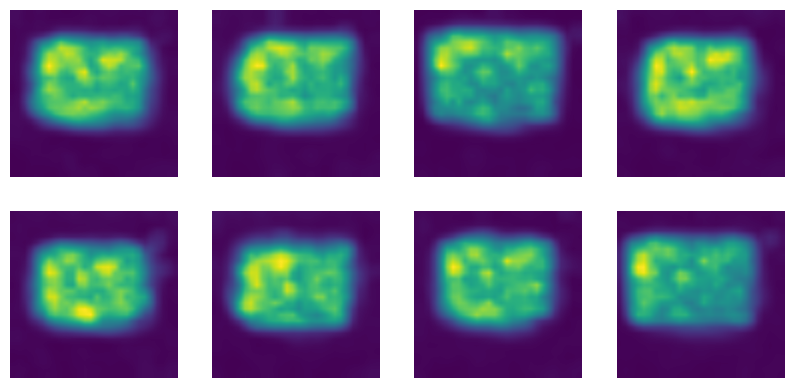

In [ ]:
# Predict all images for training data
# y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred = predict_perpdiff(test_dataset, autoencoder_model)
y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred = predict_perpdiff(test_dataset, test_dataset)

# Get min max for normalization
min_norm, max_norm = compute_min_max(perp_input, perp_pred)

# Calculate perceptual anomaly map
all_perp, y_pred_all = calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm)
show_generated_images(all_perp)